In [1]:
!pip install geopandas pyarrow matplotlib shapely
import geopandas as gpd
import math
import shapely
from shapely.ops import polygonize
from shapely.ops import nearest_points
import itertools

DEPRECATION: Loading egg at /usr/lib/python3.12/site-packages/airgraph_ng-1.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/lib/python3.12/site-packages/airdrop_ng-1.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
df = gpd.read_parquet("02-55-5505-100_EG.parquet")
df["level"] = df["level"].astype("category")
df["type"] = df["type"].astype("category")

# the current extraction logic is a bit messy with this => lets split for better analysis
df["super_type"] = df["name"].map(lambda s: s.split(" | ")[0])
df["sub_type_id"] = df["name"].map(lambda s: int(s.split("(")[1].strip(")")))
df["sub_type"] = df["name"].map(lambda s: s.split("(")[0].split(" | ")[1]).astype("category")
df.rename({"heights": "height"})  # todo: remove once reprocessed
df.drop("name", inplace=True, axis=1)

In [ ]:
doors = df[df["type"] == "door"].copy(deep=True)
spaces = df[df["type"] == "space"].copy(deep=True)

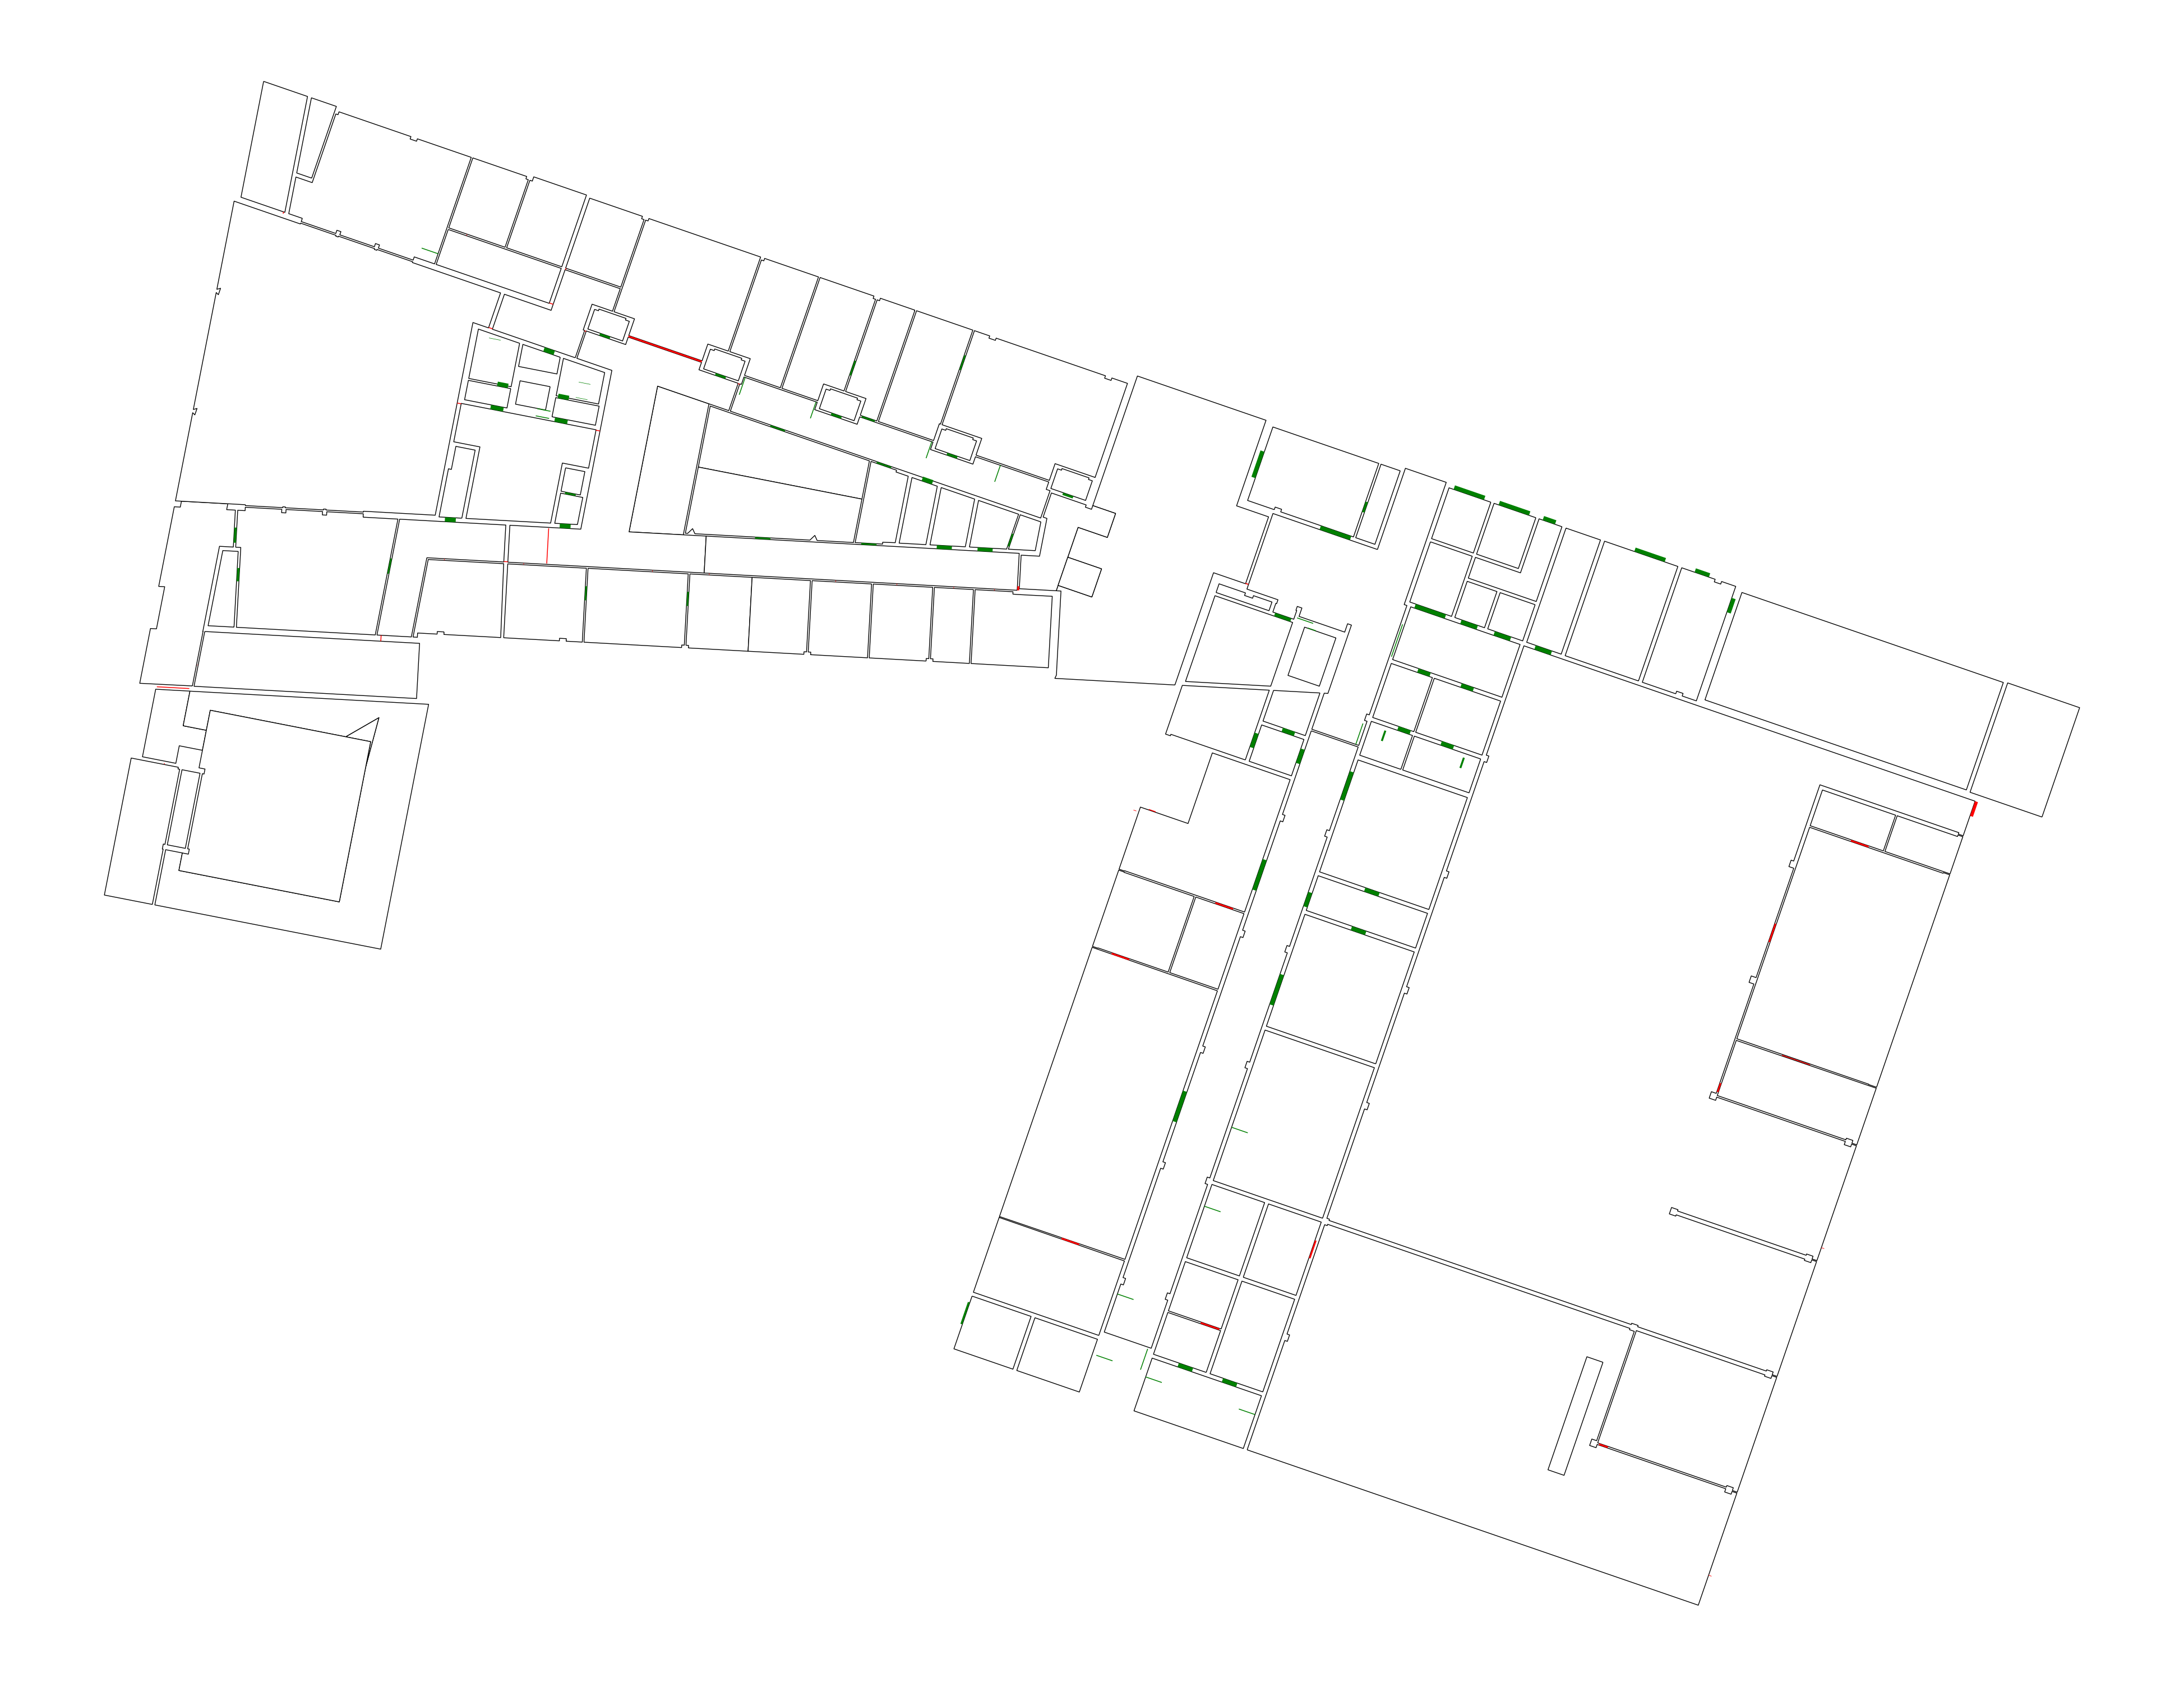

In [3]:
ax = spaces.plot(color="white", edgecolor="black", figsize=(50, 50))
ax.set_axis_off()
doors.plot(ax=ax, marker="x", color="green", markersize=100)

In [4]:
doors["width"] = doors["geometry"].minimum_bounding_circle().area.map(lambda a: 2 * math.sqrt(a / math.pi))
# ø = 2 · √(A / π)
doors["geometry"] = doors["geometry"].centroid
doors.drop("type", axis=1, inplace=True)
doors

,heights,geometry,level,super_type,sub_type_id,sub_type,width
0,2.2,POINT (76533.291 77349.495),0,DOOR,1,Drehflügel 1-flg.,0.688578
1,2.2,POINT (76526.537 77349.867),0,DOOR,2,Drehflügel 1-flg.,0.688578
2,2.2,POINT (76532.347 77359.785),0,DOOR,3,Drehflügel 1-flg.,0.688578
3,1.8,POINT (76535.623 77360.666),0,DOOR,4,Drehflügel 1-flg.,0.653029
4,1.8,POINT (76542.43 77358.323),0,DOOR,5,Drehflügel 1-flg.,0.653029
...,...,...,...,...,...,...,...
120,NaN,POINT (76563.004 77307.432),0,DOORWINDOWASSEMBLY,12,TFK Skizze,1.100989
121,NaN,POINT (76565.949 77324.186),0,DOORWINDOWASSEMBLY,13,TFK Skizze,1.100989
122,NaN,POINT (76572.05 77327.161),0,DOORWINDOWASSEMBLY,14,TFK Skizze,1.100989
123,NaN,POINT (76567.818 77332.764),0,DOORWINDOWASSEMBLY,16,TFK Skizze,0.426557


In [5]:
spaces.drop(["type", "super_type", "sub_type_id", "sub_type"], axis=1, inplace=True)
spaces

,heights,geometry,level
125,3.15,"POLYGON ((76511.366 77340.096, 76508.271 77340...",0
126,3.15,"POLYGON ((76526.169 77343.272, 76525.77 77343....",0
127,3.15,"POLYGON ((76529.675 77342.929, 76529.915 77347...",0
128,3.15,"POLYGON ((76530.36 77356.087, 76531.93 77355.7...",0
129,3.15,"POLYGON ((76532.407 77357.692, 76532.138 77356...",0
...,...,...,...
236,3.15,"POLYGON ((76581.064 77348.118, 76582.708 77352...",0
237,3.15,"POLYGON ((76577.17 77337.455, 76579.931 77336....",0
238,3.15,"POLYGON ((76569.773 77340.359, 76571.509 77345...",0
239,3.15,"POLYGON ((76576.742 77336.947, 76576.006 77334...",0


<Axes: >

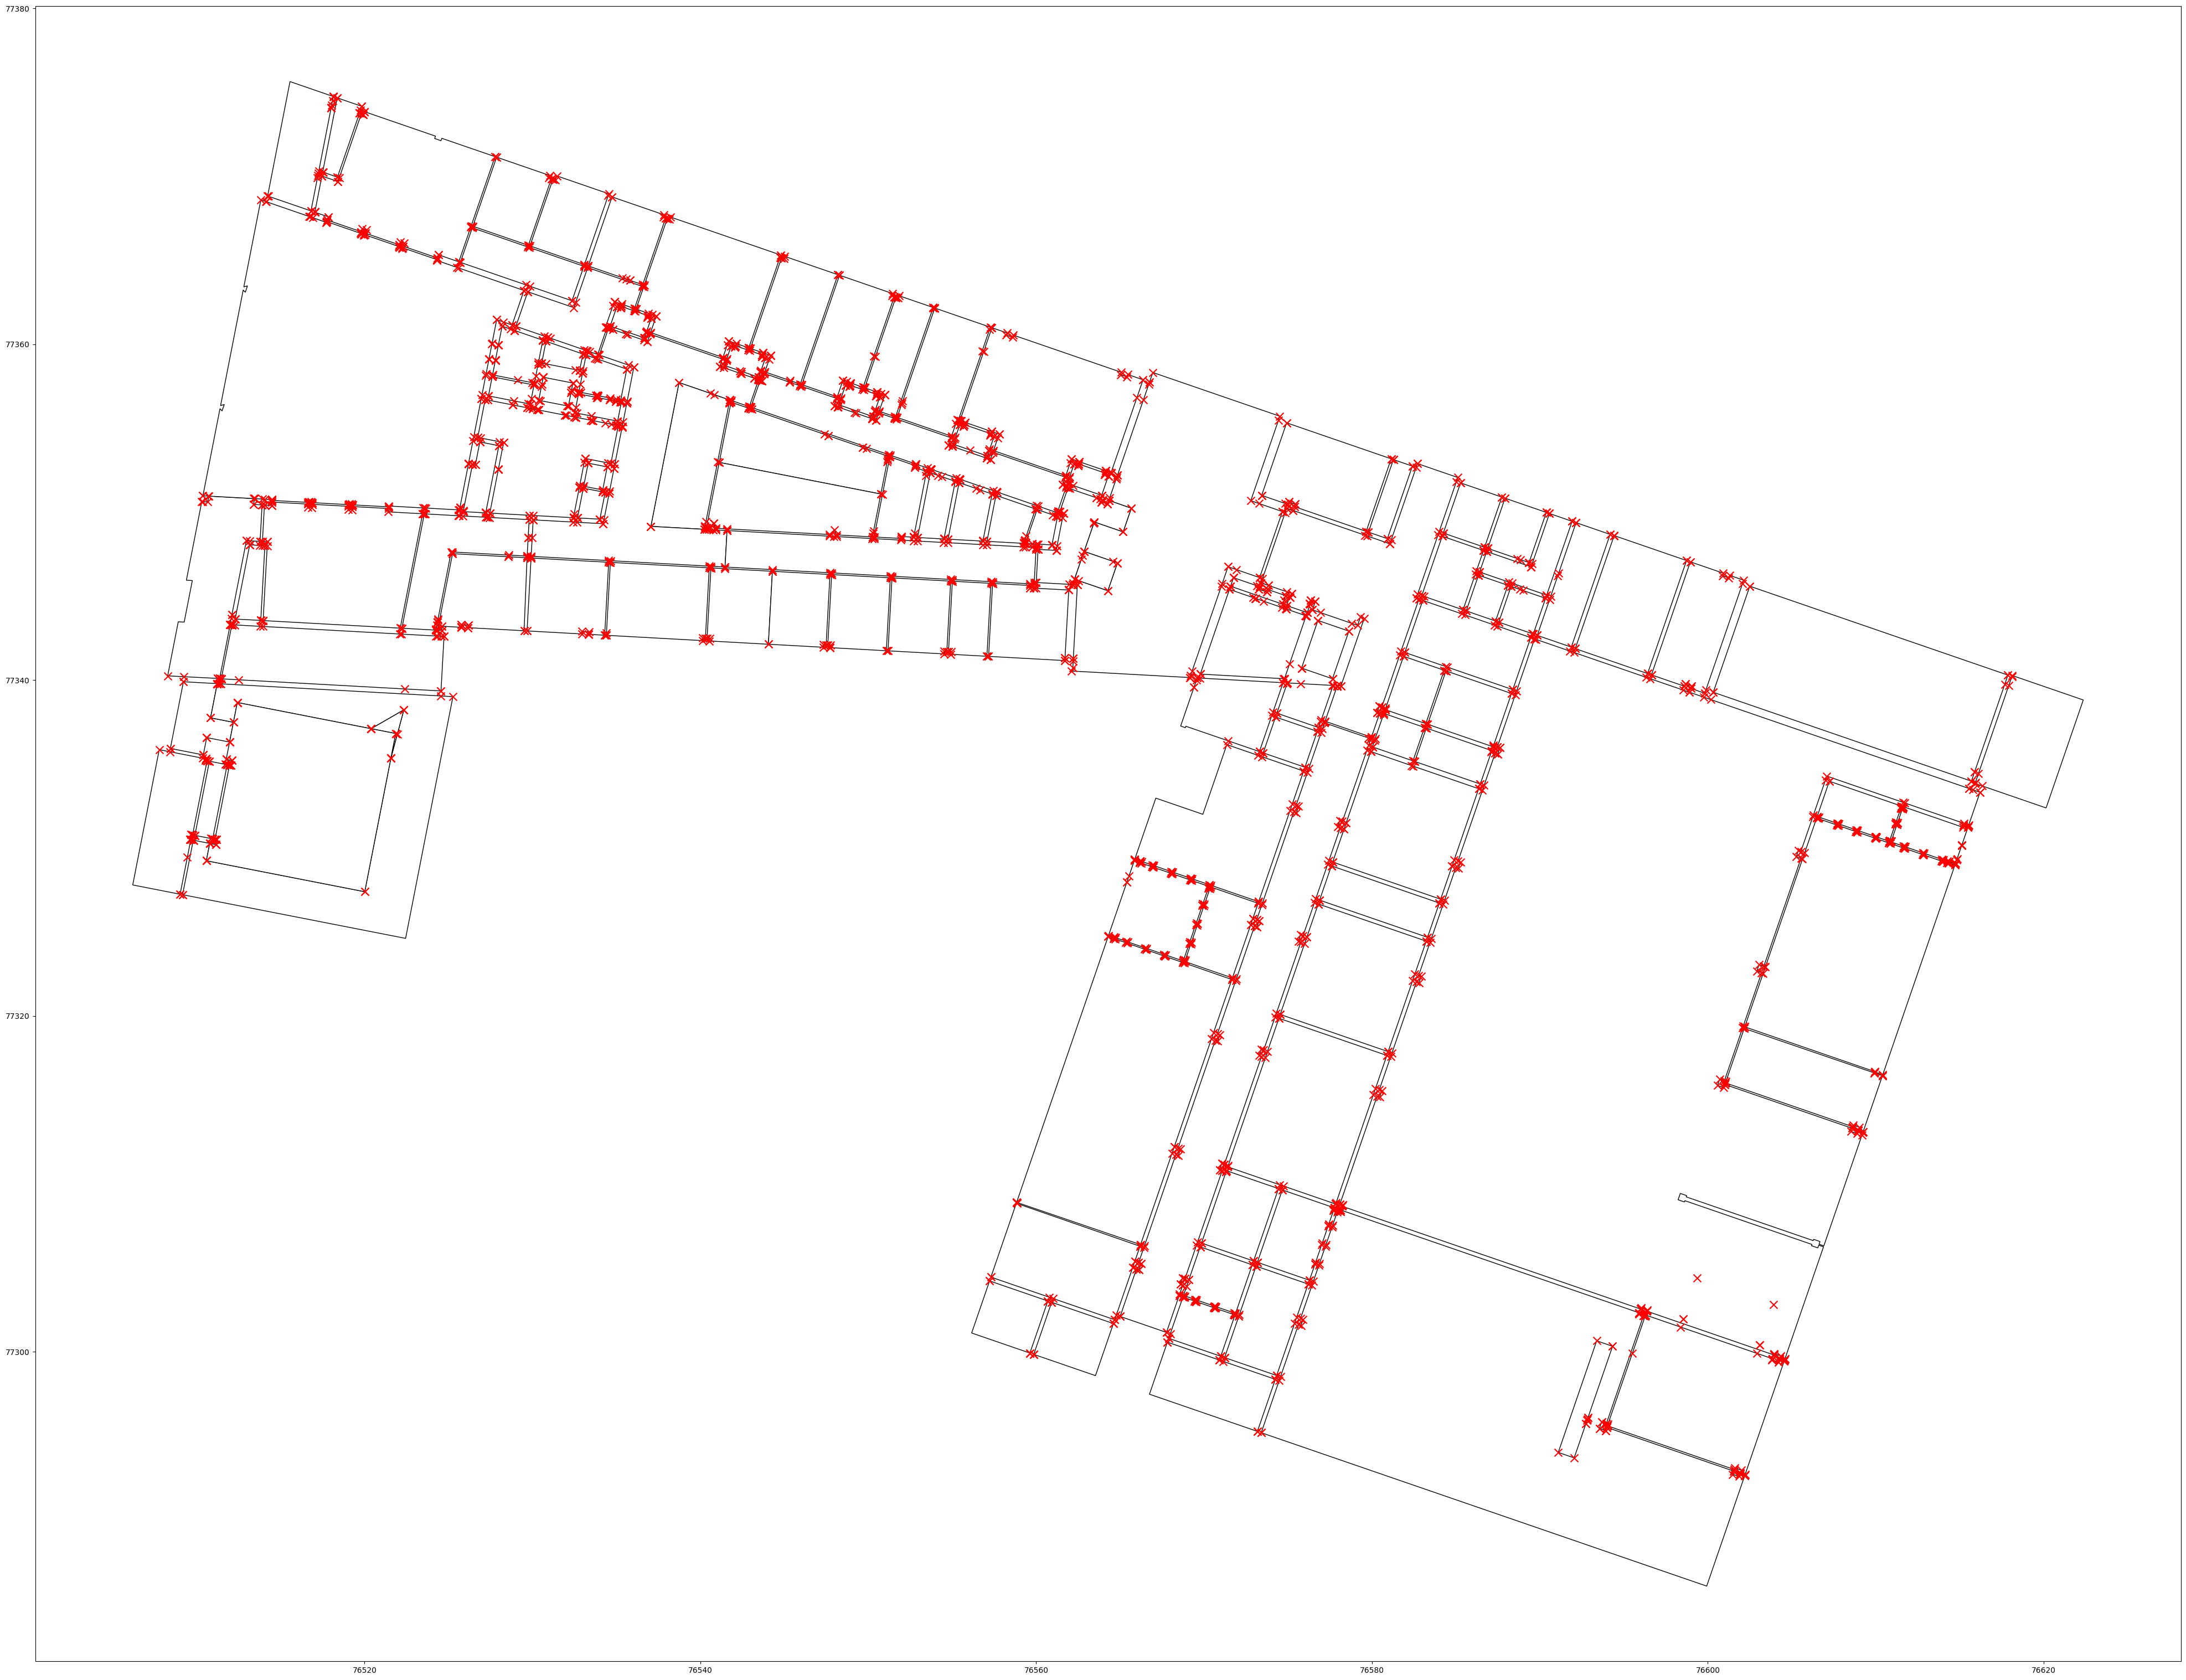

In [9]:
def generate_new_points(geom: gpd.GeoSeries) -> dict[int, set[(float, float)]]:
    points_to_add: dict[int, set[(float, float)]] = dict()
    g1: shapely.Polygon
    g2: shapely.Polygon
    for i1, geometry_1 in enumerate(geom):
        for x, y in zip(*geometry_1.exterior.coords.xy):
            point = shapely.Point(x, y)
            for i2, geometry_2 in enumerate(geom):
                if i2 == i1:  # matching itsself does not make sense
                    continue
                distance = geometry_2.distance(point)
                if distance > 2:
                    continue  # semi arbitrary cutoff after which merging does not make sense
                # insert point perpendicular
                points_to_add.setdefault(i2, set())
                for perpendicular_point in nearest_points(geometry_2, point):
                    points_to_add[i2].add(perpendicular_point)

    return points_to_add


hallucinated_points = generate_new_points(spaces.geometry).values()

In [ ]:
def visualise_hallucinated_points(hallucinated_points):
    points_to_add_list = list(itertools.chain.from_iterable(hallucinated_points))
    hallucinated_point_df = gpd.GeoDataFrame(geometry=list(points_to_add_list), crs=df.crs)
    ax = spaces.plot(color="white", edgecolor="black", figsize=(50, 50))
    ax.set_axis_off()
    hallucinated_point_df.plot(ax=ax, marker="x", color="red", markersize=100)


visualise_hallucinated_points(hallucinated_points)

In [ ]:
def add_points_to_geom(points: set[shapely.Point], geom: shapely.Polygon):
    # from https://gis.stackexchange.com/questions/188594/how-can-i-add-points-to-a-linestring-in-shapely
    # Per https://gis.stackexchange.com/questions/188594/how-can-i-add-points-to-a-linestring-in-shapely
    ring = shapely.LineString(points)
    union = ring.union(geom)
    return polygonize(union)[0]